In [ ]:
import torch
import numpy
import os
import sys

we want to train 20 models with 0.05, 0.1, 0.15, 0.2, ...0.95 of all points in a trip to predict the destination and see how the prediction varies depending on the subset of data that is given. We use a multi-layer LSTM to do the prediction.

Input of the neural net is the raw gps point concatenated with the timestamp.

we have 3 different neural networks at the end to predict time of end of trip

In [ ]:
class DestinationLSTM(nn.Module()):
    
    def __init__(self, hidden_size=128):
        super(DestinationLSTM, self).__init__()
        
        self.lstm = nn.LSTM()
        
        self.long_regressor = nn.Linear(in_features=hidden_size, out_features=1)
        self.lat_regressor = nn.Linear(in_features=hidden_size, out_features=1)
        
        self.hidden0 = nn.Parameter(torch.randn(num_layers, 1, hidden_size) * 0.05)
        self.cell0 = nn.Parameter(torch.randn(num_layers, 1, hidden_size) * 0.05)
        
    def forward(self, x):
        
        self._init_hidden()
        
        x, (self.hidden, self.cell) = self.lstm(x, (self.hidden, self.cell))
        
        long = self.long_regressor(x[-1])
        lat = self.lat_regressor(x[-1])
        
        return (lat, long)

    def _init_hidden(self):
        
        self.hidden = self.hidden0.clone().repeat(1, self.batch_size, 1).to(device)
        self.cell = self.cell0.clone().repeat(1, self.batch_size, 1).to(device)


In [ ]:
def train(model):
    
    pass

In [ ]:
def eval(model):
    
    pass

## Loading the data

In [15]:
download_url = "https://download.microsoft.com/download/F/4/8/F4894AA5-FDBC-481E-9285-D5F8C4C4F039/Geolife%20Trajectories%201.3.zip"
folder_name = 'geolife_trajectories'

In [16]:
import os
import sys
import requests
import zipfile
import io
import pandas as pd

if not os.path.exists(os.path.join(os.getcwd(), folder_name)):
    
    r = requests.get(download_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    os.rename("Geolife Trajectories 1.3", folder_name)

In [17]:
# trip length distribution

trip_lengths = []

# loop over users
for user in os.listdir(os.path.join(os.getcwd(), folder_name, "Data")):
    print(user)
    user_path = os.path.join(os.getcwd(), folder_name, "Data", user)
    # loop over trips of each person
    for trip in os.listdir(os.path.join(user_path, "Trajectory")):
        trip_path = os.path.join(user_path, "Trajectory", trip)
        
        data = pd.read_csv(trip_path, header=None, skiprows=6)
        
        trip_lengths.append(len(data))


000
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
071
072
073
074
075
076
077
078
079
080
081
082
083
084
085
086
087
088
089
090
091
092
093
094
095
096
097
098
099
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181


(array([483, 411, 448, 392, 378, 392, 415, 412, 442, 373, 344, 349, 336,
       307, 319, 283, 309, 248, 244, 229, 245, 215, 227, 190, 209, 193,
       207, 199, 203, 152, 177, 160, 154, 109, 132, 133, 146, 109, 111,
        93, 107, 115,  99,  98, 104, 101,  87,  72,  74,  81,  81,  62,
        86,  74,  70,  61,  68,  76,  65,  57,  53,  52,  60,  55,  55,
        60,  63,  59,  56,  48,  65,  40,  47,  44,  40,  43,  42,  36,
        41,  50,  39,  41,  38,  38,  30,  35,  39,  35,  41,  42,  45,
        40,  48,  29,  49,  45,  48,  23,  32,  38]), array([  50. ,   69.5,   89. ,  108.5,  128. ,  147.5,  167. ,  186.5,
        206. ,  225.5,  245. ,  264.5,  284. ,  303.5,  323. ,  342.5,
        362. ,  381.5,  401. ,  420.5,  440. ,  459.5,  479. ,  498.5,
        518. ,  537.5,  557. ,  576.5,  596. ,  615.5,  635. ,  654.5,
        674. ,  693.5,  713. ,  732.5,  752. ,  771.5,  791. ,  810.5,
        830. ,  849.5,  869. ,  888.5,  908. ,  927.5,  947. ,  966.5,
        986. , 

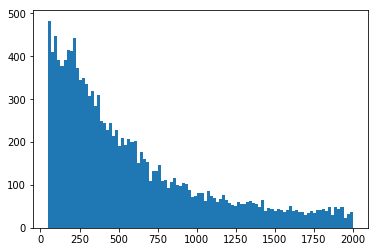

In [32]:
import numpy as np
import matplotlib.pyplot as plt

hist = np.histogram(trip_lengths, bins=100, range=(50, 2000))
print(hist)
print(np.cumsum(hist[0]) / np.sum(hist[0]))

print(np.sum(hist[0]))

plt.hist(trip_lengths, bins=100, range=(50,2000))
plt.show()

Some trips are super long. we decide to keep 90% of the data (up to trips of length 2000), we also don't keep trips of length < 50.

10000 for training, 2000 for validation, 1900 for test

# TODO

* split dataset as train, valid, test
* sort these by input_size for faster processing using lstm
* preprocessing further


In [41]:
# trip length distribution

upper = 2000
lower = 50

combined_dset = []

# loop over users
for user in os.listdir(os.path.join(os.getcwd(), folder_name, "Data")):
    print("%d / %d" % (int(user), len(os.listdir(os.path.join(os.getcwd(), folder_name, "Data")))))
    user_path = os.path.join(os.getcwd(), folder_name, "Data", user)
    # loop over trips of each person
    for trip in os.listdir(os.path.join(user_path, "Trajectory")):
        trip_path = os.path.join(user_path, "Trajectory", trip)
        
        data = pd.read_csv(trip_path, header=None, skiprows=6)
        
        if len(data) < lower or len(data) > upper:
            continue
        
        latitudes = data.iloc[:,0].values
        longitudes = data.iloc[:,1].values
        
        trajectory = [[latitudes[i], longitudes[i]] for i in range(len(data))]
        target = [latitudes[-1], longitudes[-1]]
        
        combined_dset.append((trajectory, target))


0 / 182
1 / 182
2 / 182
3 / 182
4 / 182
5 / 182
6 / 182
7 / 182
8 / 182
9 / 182
10 / 182
11 / 182
12 / 182
13 / 182
14 / 182
15 / 182
16 / 182
17 / 182
18 / 182
19 / 182
20 / 182
21 / 182
22 / 182
23 / 182
24 / 182
25 / 182
26 / 182
27 / 182
28 / 182
29 / 182
30 / 182
31 / 182
32 / 182
33 / 182
34 / 182
35 / 182
36 / 182
37 / 182
38 / 182
39 / 182
40 / 182
41 / 182
42 / 182
43 / 182
44 / 182
45 / 182
46 / 182
47 / 182
48 / 182
49 / 182
50 / 182
51 / 182
52 / 182
53 / 182
54 / 182
55 / 182
56 / 182
57 / 182
58 / 182
59 / 182
60 / 182
61 / 182
62 / 182
63 / 182
64 / 182
65 / 182
66 / 182
67 / 182
68 / 182
69 / 182
70 / 182
71 / 182
72 / 182
73 / 182
74 / 182
75 / 182
76 / 182
77 / 182
78 / 182
79 / 182
80 / 182
81 / 182
82 / 182
83 / 182
84 / 182
85 / 182
86 / 182
87 / 182
88 / 182
89 / 182
90 / 182
91 / 182
92 / 182
93 / 182
94 / 182
95 / 182
96 / 182
97 / 182
98 / 182
99 / 182
100 / 182
101 / 182
102 / 182
103 / 182
104 / 182
105 / 182
106 / 182
107 / 182
108 / 182
109 / 182
110 / 182


In [39]:
print(combined_dset[0])

([[39.984702, 116.318417], [39.984683000000004, 116.31845], [39.984685999999996, 116.318417], [39.984688, 116.318385], [39.984655, 116.31826299999999], [39.984611, 116.318026], [39.984608, 116.317761], [39.984563, 116.317517], [39.984539, 116.31729399999999], [39.984606, 116.31706499999999], [39.984567999999996, 116.316911], [39.984586, 116.31671599999999], [39.984561, 116.31652700000001], [39.984536, 116.316354], [39.984522999999996, 116.31618799999998], [39.984516, 116.31596299999998], [39.984522999999996, 116.315823], [39.984574, 116.315611], [39.984567999999996, 116.31540700000001], [39.984538, 116.315148], [39.984501, 116.314907], [39.984532, 116.31480800000001], [39.984504, 116.314625], [39.984485, 116.314426], [39.984427000000004, 116.31423999999998], [39.984485, 116.31404199999999], [39.98448, 116.313818], [39.984501, 116.31365900000002], [39.984618, 116.314323], [39.984649, 116.314107], [39.984621000000004, 116.31394099999999], [39.984655, 116.313724], [39.984681, 116.313521],

In [42]:
print(len(combined_dset))

13900


In [47]:
np.random.shuffle(combined_dset)

In [50]:
train_cutoff = 10000
valid_cutoff = 12000
train_dset = combined_dset[:train_cutoff]
valid_dset = combined_dset[train_cutoff:valid_cutoff]
test_dset = combined_dset[valid_cutoff:]


In [54]:
# convert to json
def convert_dset_to_json(dataset):
    
    dataset_json = []
    for elem in dataset:
        dataset_json.append({})
        dataset_json[-1]["input"] = elem[0]
        dataset_json[-1]["target"] = elem[1]
    
    return dataset_json

import json
# saving training set
with open(os.path.join(os.getcwd(), 'train.json'), 'w') as json_file:
    json.dump(convert_dset_to_json(train_dset), json_file)
    
# saving valid set
with open(os.path.join(os.getcwd(), 'valid.json'), 'w') as json_file:
    json.dump(convert_dset_to_json(valid_dset), json_file)
    
# saving valid set
with open(os.path.join(os.getcwd(), 'test.json'), 'w') as json_file:
    json.dump(convert_dset_to_json(test_dset), json_file)